In [4]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data import *
%matplotlib widget

In [5]:
def decode_particle_id(data):
    """Decode particle_id into vertex id, generation, etc.
    """
    components = [
        ('vertex_id',    0xfff0000000000000, 13 * 4),
        ('primary_id',   0x000ffff000000000, 9 * 4),
        ('generation',   0x0000000fff000000, 6 * 4),
        ('secondary_id', 0x0000000000fff000, 3 * 4),
        ('process',      0x0000000000000fff, 0),
    ]
    pid = data['particle_id'].values.astype('u8')
    for name, mask, shift in components:
        data[name] = (pid & mask) >> shift
    return data

In [6]:
def distance(h1, h2):
    distance = math.sqrt((h2.x - h1.x) ** 2 + (h2.y - h1.y) ** 2 + (h2.z - h1.z) ** 2)
    return distance

In [7]:
def count_particle_layer(merged_df):
    layer_id_list =  list(set(merged_df['layer_id']))
    particle_by_layer = dict()
    for l in layer_id_list:
        d =  merged_df[merged_df['layer_id']==l]
        particle_by_layer[l] =  list(set(d['particle_id']))
        # print(set(dataset_3[dataset_3['particle_id'].isin(seclect)]
    # for k, v in particle_by_layer.items():
    #     print(k, len(v))
    return particle_by_layer

In [8]:
def load_hits(df):
    list_df = [row.tolist() for index, row in df.iterrows()]
    volumes = dict()
    
    for i in list_df:
        hit = Hit(
                  hit_id=i[0],
                  x=i[1],
                  y=i[2],
                  z=i[3],
                  volume_id=i[4],
                  layer_id =i[5],
                  module_id = i[6],
                  particle_id = i[7]
                  )
        volume_id = int(hit.volume_id)
        if volume_id not in volumes:
            volumes[volume_id] = [hit]
        else:
            volumes[volume_id] += [hit]
    for id, hits in volumes.items():
        layers = dict()
        for hit in hits:
            layer_id = int(hit.layer_id)
            if layer_id not in layers:
                layers[layer_id] = [hit]
            else:
                layers[layer_id] += [hit]
        volumes[id] = layers
    return volumes

In [9]:
def display(hits, segments):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    layers = list(hits.keys())
    xs = []
    ys = []
    zs = []

    for p in layers:
        h_p = hits[p]
        for h in h_p:
            xs.append(h.x)
            ys.append(h.y)
            zs.append(h.z)
    ax.scatter(xs, ys, zs, marker='o', color='red')

    for track, hits in segments.items():
        for i in range(len(hits)-1):
            h1 = hits[i]
            h2 = hits[i+1]
            ax.plot(xs=[h1.x, h2.x], ys=[h1.y, h2.y], zs=[h1.z, h2.z], color='blue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [18]:
# get hits from second sublayer in volume 9
volume_9 = pd.read_csv("event000001000/volume_id_9/event000001000-volume_id_9.csv")
volume_9

,hit_id,x,y,z,volume_id,layer_id,module_id
0,46117,-111.575,-12.45930,598.0,9,2,3
1,46118,-102.945,-18.67670,598.0,9,2,3
2,46119,-108.234,-10.83210,598.0,9,2,3
3,46120,-112.229,-7.95649,598.0,9,2,3
4,46121,-119.432,-13.30280,598.0,9,2,3
...,...,...,...,...,...,...,...
5511,63227,-175.764,4.27339,1498.0,9,14,108
5512,63228,-151.434,13.83350,1498.0,9,14,108
5513,63229,-106.587,-3.00565,1498.0,9,14,108
5514,63230,-160.443,14.75060,1498.0,9,14,108


In [19]:
# read all truth particle
truth_hits_wo_noise = pd.read_csv("event000001000/event000001000-truth-wo-noise.csv")
truth_hits_wo_noise = decode_particle_id(truth_hits_wo_noise)
truth_hits_wo_noise

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vertex_id,primary_id,generation,secondary_id,process
0,2,22525763437723648,-55.3385,0.630805,-1502.5,-0.570605,0.028390,-15.492200,0.000010,5,113,0,0,0
1,4,297237712845406208,-96.1229,-8.230360,-1502.5,-0.225235,-0.050968,-3.702320,0.000008,66,2,0,0,0
2,5,418835796137607168,-62.6594,-9.375040,-1502.5,-0.281806,-0.023487,-6.573180,0.000009,93,15,0,0,0
3,6,108087696726949888,-57.0856,-8.189710,-1502.5,-0.401129,-0.035276,-10.466900,0.000008,24,19,0,0,0
4,7,968286151951515648,-73.8608,-2.575860,-1502.5,-0.442662,-0.036969,-9.130100,0.000007,215,178,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103300,120935,445864815605317632,-763.3840,51.545000,2944.5,-1.640200,0.208933,6.293810,0.000018,99,123,0,0,0
103301,120936,900720956266250240,-804.6650,3.186900,2944.5,-0.315684,-0.094259,1.328200,0.000007,200,15,0,0,0
103302,120937,238705348779704320,-986.9890,41.731300,2952.5,-0.212508,0.095667,0.731932,0.000009,53,212,0,0,0
103303,120938,373800349619716096,-947.0050,18.765000,2952.5,-0.165762,-0.103945,0.800783,0.000007,83,23,0,0,0


In [20]:
particles_in_volumn_9 = truth_hits_wo_noise[truth_hits_wo_noise['hit_id'].isin(volume_9['hit_id'])]
particles_in_volumn_9

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vertex_id,primary_id,generation,secondary_id,process
43168,46117,333267334498091008,-111.572,-12.47600,598.0,-0.322595,-0.001786,1.71496,0.000009,74,14,0,0,0
43169,46118,860203196868460544,-102.946,-18.67000,598.0,-0.671653,0.030952,3.51559,0.000023,191,228,0,0,0
43170,46119,49542963155435520,-108.235,-10.82050,598.0,-0.518487,-0.019823,2.83545,0.000008,11,49,0,0,0
43171,46120,274723769157681152,-112.229,-7.97334,598.0,-0.324477,0.012420,1.71119,0.000009,61,61,0,0,0
43172,46121,157626261835874304,-119.427,-13.32250,598.0,-0.398539,-0.079798,1.98732,0.000008,35,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59505,63226,558457142751789056,-122.960,12.70980,1498.0,-0.192101,-0.017154,2.34164,0.000006,124,157,0,0,0
59506,63228,837676814955446272,-151.439,13.84820,1498.0,-2.412120,0.171231,24.02410,0.000015,186,106,0,0,0
59507,63229,797143799833821184,-106.570,-2.99934,1498.0,-0.348907,-0.045725,4.97316,0.000007,177,97,0,0,0
59508,63230,58547138753200128,-160.448,14.76500,1498.0,-0.230050,-0.024821,2.14526,0.000004,13,5,0,0,0


In [21]:
particle_id = list(set(particles_in_volumn_9['particle_id']))
len(particle_id)

1674

In [22]:
# merged_df = volume_9.merge(particles_in_volumn_9[['hit_id', 'vertex_id','primary_id','generation','secondary_id']], on='hit_id', how='left').dropna()
merged_df = volume_9.merge(particles_in_volumn_9[['hit_id', 'particle_id']], on='hit_id', how='left').dropna()
merged_df

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id
0,46117,-111.575,-12.45930,598.0,9,2,3,3.332673e+17
1,46118,-102.945,-18.67670,598.0,9,2,3,8.602032e+17
2,46119,-108.234,-10.83210,598.0,9,2,3,4.954296e+16
3,46120,-112.229,-7.95649,598.0,9,2,3,2.747238e+17
4,46121,-119.432,-13.30280,598.0,9,2,3,1.576263e+17
...,...,...,...,...,...,...,...,...
5510,63226,-122.971,12.71780,1498.0,9,14,108,5.584571e+17
5512,63228,-151.434,13.83350,1498.0,9,14,108,8.376768e+17
5513,63229,-106.587,-3.00565,1498.0,9,14,108,7.971438e+17
5514,63230,-160.443,14.75060,1498.0,9,14,108,5.854714e+16


In [23]:
particle_by_layer = count_particle_layer(merged_df)
for k, v in particle_by_layer.items():
    print(k, len(v))

2 888
4 907
6 868
8 758
10 683
12 594
14 516


In [24]:
import random
particle_by_layer = count_particle_layer(merged_df)
keys = list(particle_by_layer.keys())
smallest =  list(particle_by_layer[14])
select_particle_id = set()

for i in smallest:
    do_select = 0
    for k in keys[:-1]:
        if i in particle_by_layer[k]:
            do_select+=1
    if do_select == len(keys[:-1]):
        select_particle_id.add(i)
selected_particle_id =  list(select_particle_id)
print(len(selected_particle_id))

131


In [43]:
N = 1
idx = set()
while len(idx) < N:
    idx.add(random.randint(0, len(selected_particle_id)-1))
len(idx)

rand_particles = []
for i in idx:
    rand_particles.append(selected_particle_id[i])
len(rand_particles)

1

In [44]:
df_final = merged_df[merged_df['particle_id'].isin(rand_particles)]
df_final

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id
208,46744,-0.055979,-46.2764,598.0,9,2,25,6.305198e+16
1146,49772,-0.164007,-54.0218,698.0,9,4,25,6.305198e+16
2070,52822,-0.340271,-63.2715,818.0,9,6,25,6.305198e+16
2950,55702,-0.585066,-74.0292,958.0,9,8,25,6.305198e+16
3769,58184,-0.933966,-84.8351,1098.0,9,10,25,6.305198e+16
4461,60269,-1.545070,-100.2470,1298.0,9,12,25,6.305198e+16
5097,62097,-2.286690,-115.6420,1498.0,9,14,29,6.305198e+16


In [45]:
selected_particle_by_layer = count_particle_layer(df_final)
for k, v in selected_particle_by_layer.items():
    print(k, len(v))

2 1
4 1
6 1
8 1
10 1
12 1
14 1


In [48]:
path_out = "/Users/doduydao/daodd/PycharmProjects/track/src/data_selected/1hits/known_track/hits.csv"

In [49]:
df_final.to_csv(path_out,index=False) 

In [50]:
N = 1
v_id = 9

In [51]:
path_out = "/Users/doduydao/daodd/PycharmProjects/track/src/data_selected/"+str(N)+"hits/known_track/hits.csv"

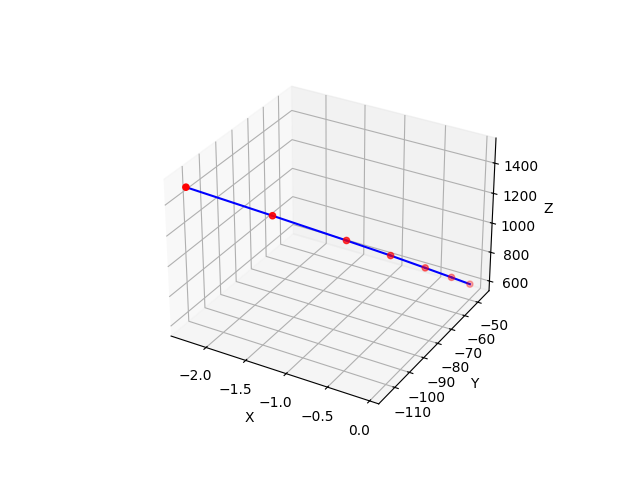

In [52]:
data_wrote = pd.read_csv(path_out)
hits = load_hits(data_wrote)[9]
track = dict()
for l, hp in hits.items():
    for i in range(len(hp)):
        id = hp[i].hit_id
        particle_id = hp[i].particle_id
        if particle_id not in track:
            track[particle_id] = [hp[i]]
        else:
            track[particle_id] += [hp[i]]
for t, h in track.items():
    h = sorted(h, key=lambda obj: obj.z)
    track[t] = h
    
# hits = load_hits(data_wrote)[9]
display(hits, track)

In [53]:
cost = 0
count = 1
for pa, hs in track.items():
    # print("track:", pa)
    t = []
    ct = 0
    for i in range(len(hs)-2):
        h_i = hs[i]
        h_j = hs[i+1]
        h_k = hs[i+2]
        seg_1 = Segment(h_j, h_i)
        seg_2 = Segment(h_j, h_k)
        angle = Angle(seg_1=seg_1, seg_2=seg_2).angle
        # dist = distance(h_i, h_j) + distance(h_j, h_k)
        # dist = 1
        beta = angle
        ct+=beta
    # print('Track', count, ':', ct)
    cost += ct
print('cost of all track is', cost)

cost of all track is 0.002951521601679996
